 -> 100x100 (Simmetrizzazione)

[METRICHE TOPOLOGICHE] - Tradizionale (101)
 > Densità: 0.8186
 > Grado Medio: 81.04
 > Clustering Coeff: 0.9486

[COMMUNITY DETECTION] - Tradizionale (101)
 > Numero Comunità trovate: 2
 > Modularità (Q): 0.0520

[BACKBONE EXTRACTION] - Tradizionale (101)
 > Tabella salvata: tabella_legami_Tradizionale.csv
 > Top 5 Legami più forti:
 Nodo A  Nodo B  Peso
     69      73    14
     31      32    12
     42      69    12
     25      26    11
     60      69    11


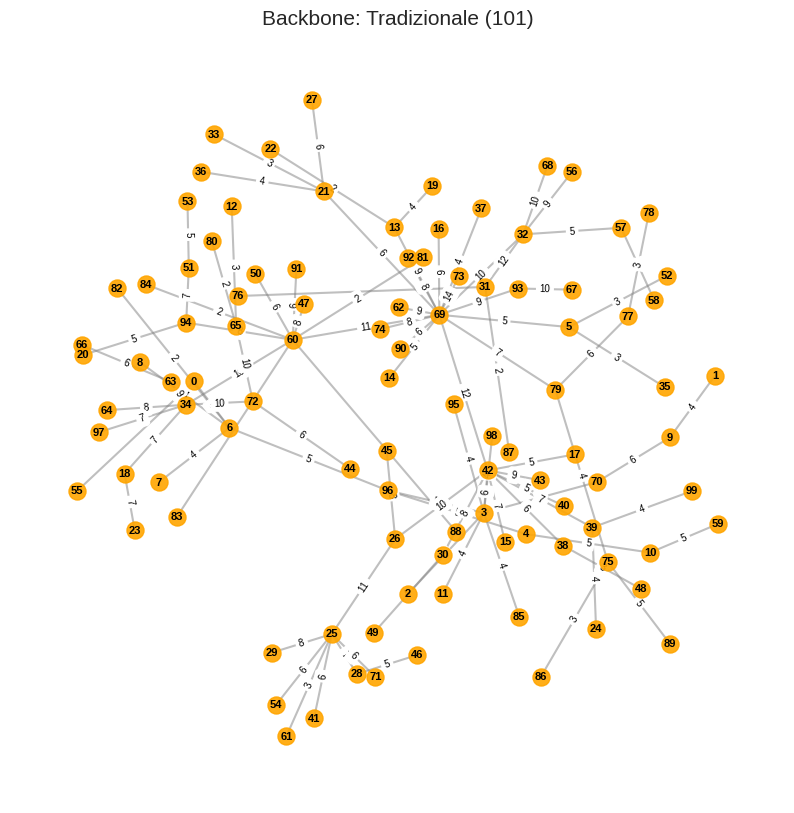

 -> 57x57 (Simmetrizzazione)

[METRICHE TOPOLOGICHE] - Alta Cucina (Roca)
 > Densità: 0.9987
 > Grado Medio: 55.93
 > Clustering Coeff: 0.9988

[COMMUNITY DETECTION] - Alta Cucina (Roca)
 > Numero Comunità trovate: 2
 > Modularità (Q): 0.0437

[BACKBONE EXTRACTION] - Alta Cucina (Roca)
 > Tabella salvata: tabella_legami_Alta.csv
 > Top 5 Legami più forti:
 Nodo A  Nodo B  Peso
     14      15    20
      4      18    18
     15      18    17
      3      35    16
     13      15    15


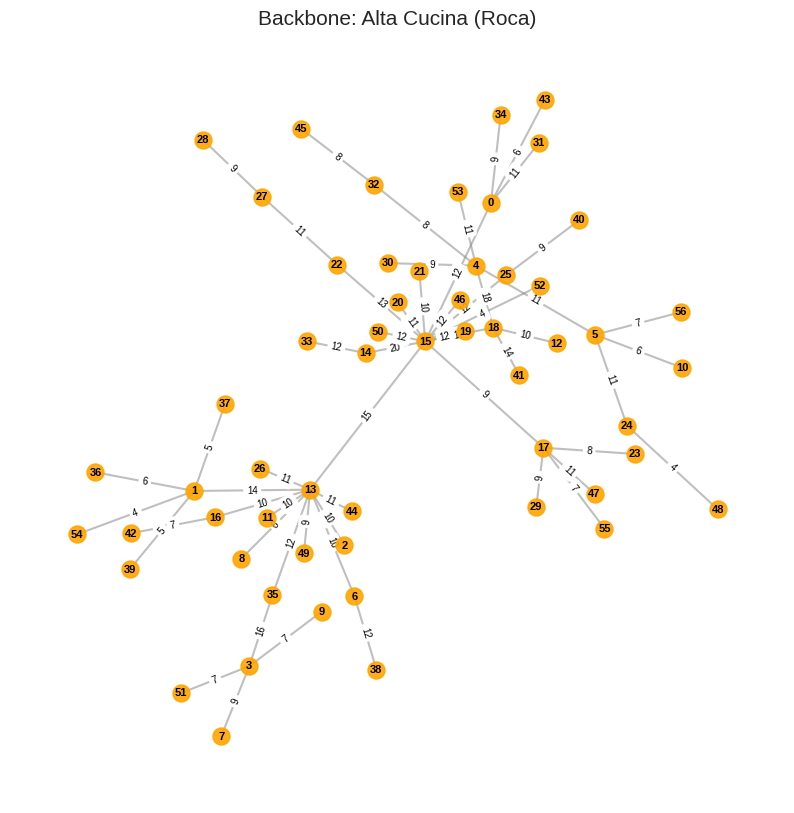

 -> 160x160 (Simmetrizzazione)

[METRICHE TOPOLOGICHE] - Substitution (Ctrad)
 > Densità: 0.9677
 > Grado Medio: 153.86
 > Clustering Coeff: 0.9826

[COMMUNITY DETECTION] - Substitution (Ctrad)
 > Numero Comunità trovate: 2
 > Modularità (Q): 0.0478

[BACKBONE EXTRACTION] - Substitution (Ctrad)
 > Tabella salvata: tabella_legami_Substitution.csv
 > Top 5 Legami più forti:
 Nodo A  Nodo B  Peso
     97      99    14
     22     136    13
      0       6    12
     14     136    12
     21     136    12


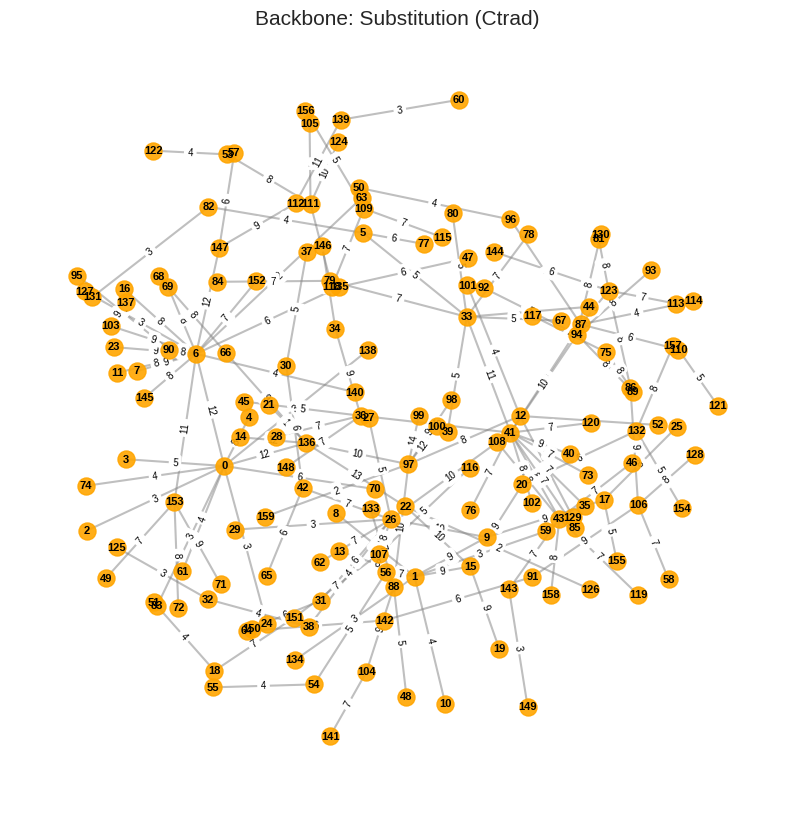

In [4]:
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

def parse_r_output_robust(filepath):
    data_map = {}

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        for line in lines:
            line = line.strip()
            if not line or line.startswith("File:") or "max.print" in line or line.startswith("Simmetrica:") or line.startswith("Matrice:"):
                continue
            if "[" in line and "]" in line and line.strip().startswith("[,"):
                continue

            match = re.match(r'^\[(\d+),\]', line)
            if match:
                row_idx = int(match.group(1))
                content = line[match.end():]
                try:
                    vals = [int(x) for x in content.split()]
                    if row_idx not in data_map:
                        data_map[row_idx] = []
                    data_map[row_idx].extend(vals)
                except ValueError:
                    continue

        if not data_map:
            print("Error: nessun dato trovato.")
            return None

        sorted_indices = sorted(data_map.keys())
        matrix_rows = [data_map[i] for i in sorted_indices]
        min_col_len = min(len(r) for r in matrix_rows)
        trimmed_rows = [r[:min_col_len] for r in matrix_rows]
        matrix = np.array(trimmed_rows)
        limit = min(matrix.shape)
        matrix = matrix[:limit, :limit]

        if np.sum(np.tril(matrix, -1)) == 0 and np.sum(np.triu(matrix, 1)) > 0:
            print(f" -> {limit}x{limit} (Simmetrizzazione)")
            matrix = matrix + matrix.T
        else:
            print(f" Recuperata sottomatrice {limit}x{limit}")

        return matrix

    except Exception as e:
        print(f"Errore lettura: {e}")
        return None

def calculate_metrics(G, name):
    print(f"\n[METRICHE TOPOLOGICHE] - {name}")

    # Densità
    density = nx.density(G)
    print(f" > Densità: {density:.4f}")

    # Grado Medio
    avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    print(f" > Grado Medio: {avg_degree:.2f}")

    G_unweighted = G.copy()
    clustering = nx.average_clustering(G_unweighted, weight=None)
    print(f" > Clustering Coeff: {clustering:.4f}")

def detect_communities(G, name):
    print(f"\n[COMMUNITY DETECTION] - {name}")

    # Algoritmo Greedy Modularity
    try:
        communities = nx_comm.greedy_modularity_communities(G, weight='weight')
        n_comm = len(communities)
        modularity = nx_comm.modularity(G, communities, weight='weight')

        print(f" > Numero Comunità trovate: {n_comm}")
        print(f" > Modularità (Q): {modularity:.4f}")

    except Exception as e:
        print(f"Errore nel calcolo comunità: {e}")

def analyze_backbone_and_table(G, name):
    print(f"\n[BACKBONE EXTRACTION] - {name}")

    # Maximum Spanning Tree
    T = nx.maximum_spanning_tree(G, weight='weight')

    edges_data = []
    for u, v, data in T.edges(data=True):
        weight = data.get('weight', 0)
        edges_data.append({
            "Nodo A": u,
            "Nodo B": v,
            "Peso": weight
        })

    df_edges = pd.DataFrame(edges_data)
    df_edges = df_edges.sort_values(by="Peso", ascending=False)

    csv_filename = f"tabella_legami_{name.split()[0]}.csv"
    df_edges.to_csv(csv_filename, index=False)

    print(f" > Tabella salvata: {csv_filename}")
    print(" > Top 5 Legami più forti:")
    print(df_edges.head(5).to_string(index=False))

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(T, k=0.5, seed=42)
    nx.draw_networkx_nodes(T, pos, node_size=150, node_color='orange', alpha=0.9)
    nx.draw_networkx_edges(T, pos, alpha=0.5, edge_color='gray', width=1.5)
    nx.draw_networkx_labels(T, pos, font_size=8, font_weight='bold')

    edge_labels = nx.get_edge_attributes(T, 'weight')
    rel_labels = {k: v for k, v in edge_labels.items() if v > 1}
    nx.draw_networkx_edge_labels(T, pos, edge_labels=rel_labels, font_size=7)

    plt.title(f"Backbone: {name}", fontsize=15)
    plt.axis('off')
    plt.show()


files = [
    ("Tradizionale (101)", "101_mat_ricette_output.txt"),
    ("Alta Cucina (Roca)", "Roca_mat_ricette_output.txt"),
    ("Substitution (Ctrad)", "Ctrad_mat_ricette_substitution_output.txt")
]

for name, path in files:
    matrix = parse_r_output_robust(path)

    if matrix is not None:
        G = nx.from_numpy_array(matrix)
        G.remove_edges_from(nx.selfloop_edges(G))
        G.remove_nodes_from(list(nx.isolates(G)))

        calculate_metrics(G, name)
        detect_communities(G, name)
        analyze_backbone_and_table(G, name)
